In [1]:
import h5py
import numpy as np
import pandas as pd
from fastcore.all import Path
import matplotlib.pyplot as plt
import seaborn as sns

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Load data

In [2]:
DATA_PATH = Path('ladle_inf_data_multi_thinspan_smooth_high//////')
DATA = list(DATA_PATH.glob('no_slag/*.h5'))
DATA

[Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-central_close_n_mu-10000.h5'),
 Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-offset_separated_n_mu-1000.h5'),
 Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-central_separated_n_mu-1000.h5'),
 Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-central_close_n_mu-1000.h5'),
 Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-central_separated_n_mu-10000.h5')]

In [3]:
def get_new_pred(poca_xyz, poca_xyz_unc, eff, xy_sig_wgt):
    r'''
    New version of inferrence with clamping
    '''
    
    z_pos = poca_xyz[:, 2:]
    z_unc = poca_xyz_unc[:, 2:]
    
    z_unc = np.clip(z_unc, np.percentile(z_unc, 15.865), np.percentile(z_unc, 84.135))
        
    wgt = xy_sig_wgt * eff / (z_unc**2)
    wgt = np.clip(wgt, 0, np.percentile(z_unc, 84.135))
    
    mean_z = (wgt * z_pos).sum() / wgt.sum()
    return mean_z[None]

In [4]:
df = pd.DataFrame()
for path in DATA:
    with h5py.File(path, 'r') as h5:
        for grp in h5.keys():
            tmp_df = pd.DataFrame({
                'detector':path.stem.split('_n_mu')[0],
                'n_mu':int(path.stem.split('-')[-1]),
                'targ_h':h5[grp]['targ_h'][()],
                'pred_h':h5[grp]['pred_h'][()],
                'n_rec_muons':h5[grp]['muon_efficiency'][()].shape[0],
                'mean_z_unc':h5[grp]['poca_xyz_unc'][:,2].mean(),
                'mean_z':h5[grp]['poca_xyz'][:,2].mean(),
                'mean_xy_unc':h5[grp]['poca_xyz_unc'][:,:2].mean(),
                'mean_xy_sig_wgt':h5[grp]['muon_xy_sig_wgt'][()].mean(),
                'std_xy_sig_wgt':h5[grp]['muon_xy_sig_wgt'][()].std(),
                'std_wgt':h5[grp]['muon_wgt'][()].std(),
                'mean_wgt':h5[grp]['muon_wgt'][()].mean(),
                'new_pred':get_new_pred(poca_xyz=h5[grp]['poca_xyz'][()], poca_xyz_unc=h5[grp]['poca_xyz_unc'][()], eff=h5[grp]['muon_efficiency'][()], xy_sig_wgt=h5[grp]['muon_xy_sig_wgt'][()])
            })
            df = df.append(tmp_df, ignore_index=True)

# Process data 

In [5]:
df['bias'] = df.targ_h-df.pred_h
df['new_bias'] = df.targ_h-df.new_pred
df['basic_bias'] = df.targ_h-df.mean_z

In [6]:
df

,detector,n_mu,targ_h,pred_h,n_rec_muons,mean_z_unc,mean_z,mean_xy_unc,mean_xy_sig_wgt,std_xy_sig_wgt,std_wgt,mean_wgt,new_pred,bias,new_bias,basic_bias
0,det-central_close,10000,0.4,0.496187,2052,1.134189,0.659549,0.159979,0.549890,0.186908,4.576799e+04,1.174956e+04,0.685371,-0.096187,-0.285371,-0.259549
1,det-central_close,10000,0.4,0.504192,2019,1.330096,0.687285,0.191751,0.550723,0.184706,5.135880e+04,1.312834e+04,0.699910,-0.104192,-0.299910,-0.287285
2,det-central_close,10000,0.4,0.472770,1995,1.492392,0.654664,0.163603,0.550332,0.189412,6.831076e+04,1.406783e+04,0.689861,-0.072770,-0.289861,-0.254664
3,det-central_close,10000,0.4,0.528312,2003,1.738766,0.670997,0.209833,0.551093,0.188189,5.277521e+04,1.482665e+04,0.692561,-0.128312,-0.292561,-0.270997
4,det-central_close,10000,0.6,0.500866,2006,1.085430,0.617339,0.143955,0.573492,0.176462,5.642859e+04,1.577536e+04,0.634601,0.099134,-0.034601,-0.017339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,det-central_separated,10000,1.2,0.486259,1306,0.038950,0.796650,0.004003,0.645288,0.148243,6.026200e+06,3.051730e+06,0.798045,0.713741,0.401955,0.403350
214,det-central_separated,10000,1.2,0.489445,1377,0.076020,0.761337,0.007833,0.632938,0.155035,6.198842e+06,3.448522e+06,0.761337,0.710555,0.438663,0.438663
215,det-central_separated,10000,1.2,0.505610,1417,0.042827,0.784456,0.004022,0.648892,0.149662,7.502611e+06,3.461192e+06,0.784455,0.694390,0.415545,0.415545
216,det-central_separated,10000,1.2,0.468158,1418,0.044814,0.797469,0.003896,0.639778,0.151883,6.233061e+06,3.237780e+06,0.797469,0.731842,0.402531,0.402531


# Interpret data 

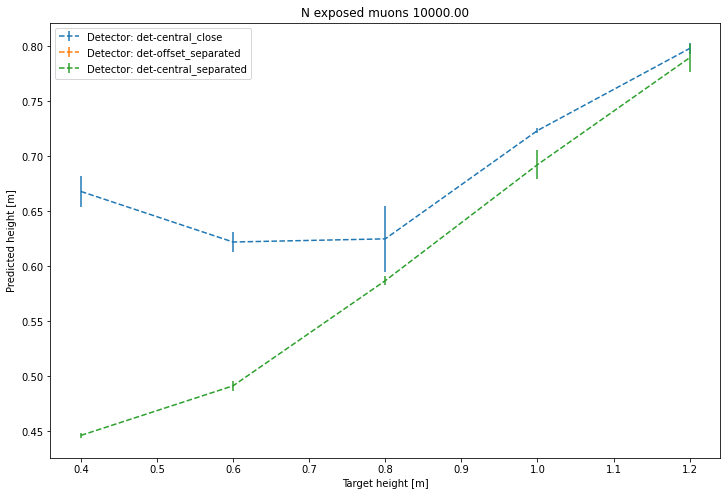

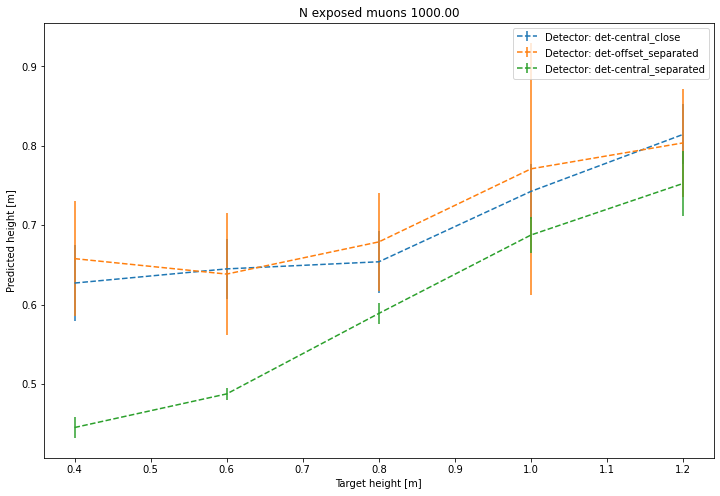

In [7]:
for n_mu in df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(df.detector.unique()):
            sdf = df[(df.detector == det) & (df.n_mu == n_mu)].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['pred_h', 'new_pred', 'mean_z']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, agg.mean_z_mean, yerr=agg.mean_z_std, label=f'Detector: {det}', color=pallete[i], linestyle='--')
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Predicted height [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

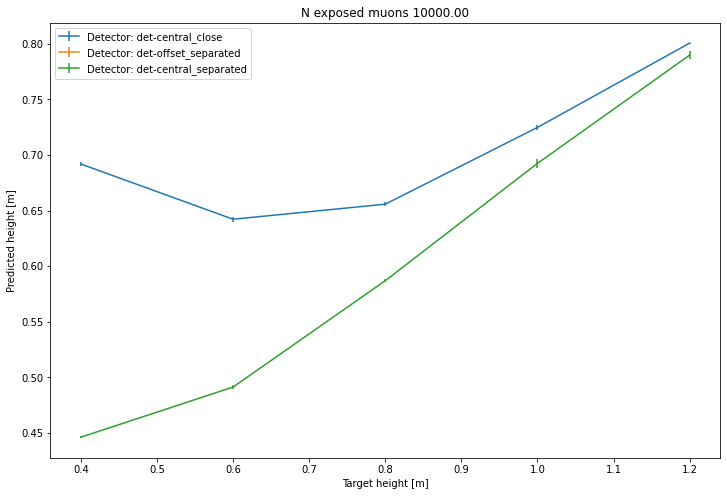

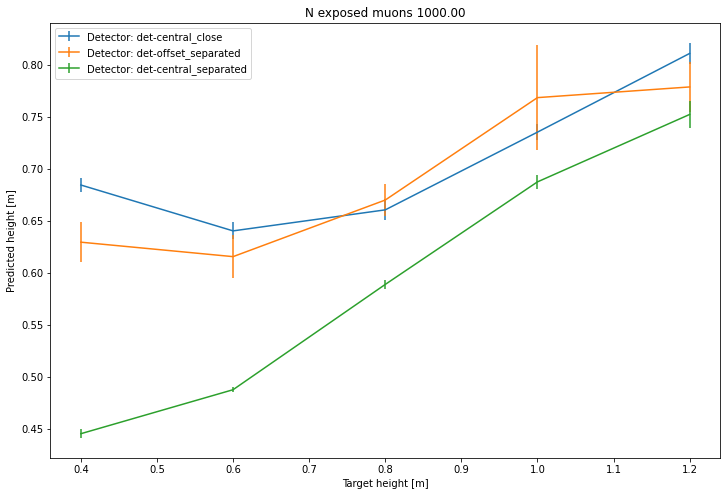

In [8]:
for n_mu in df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(df.detector.unique()):
            sdf = df.loc[(df.detector == det) & (df.n_mu == n_mu), ['targ_h', 'pred_h', 'new_pred']].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['pred_h', 'new_pred']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, agg.new_pred_mean, yerr=agg.new_pred_std/np.sqrt(10), label=f'Detector: {det}', color=pallete[i])
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Predicted height [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

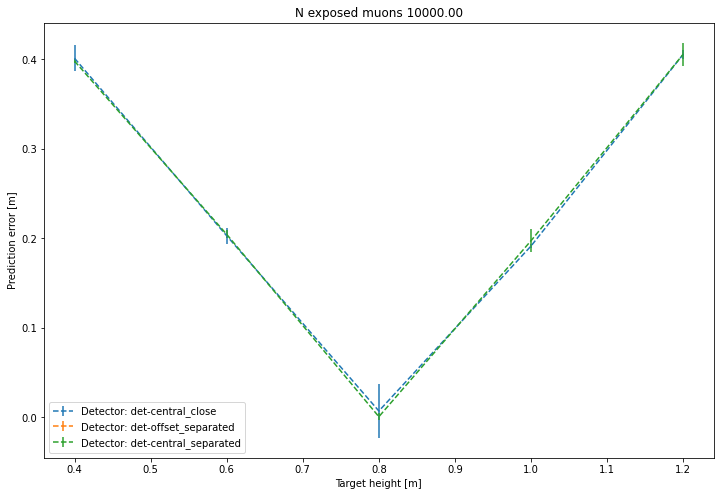

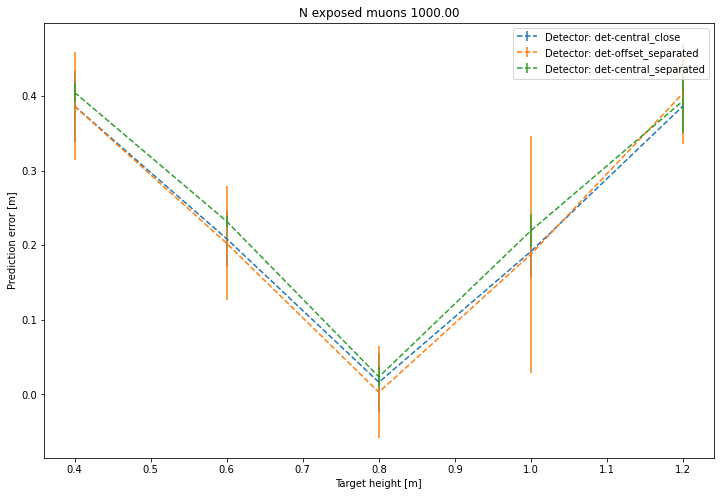

In [9]:
for n_mu in df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(df.detector.unique()):
            sdf = df[(df.detector == det) & (df.n_mu == n_mu)].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['bias', 'new_bias', 'basic_bias']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, (agg.bias_mean-agg.bias_mean.mean()).abs(), yerr=agg.basic_bias_std, label=f'Detector: {det}', color=pallete[i], linestyle='--')
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Prediction error [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

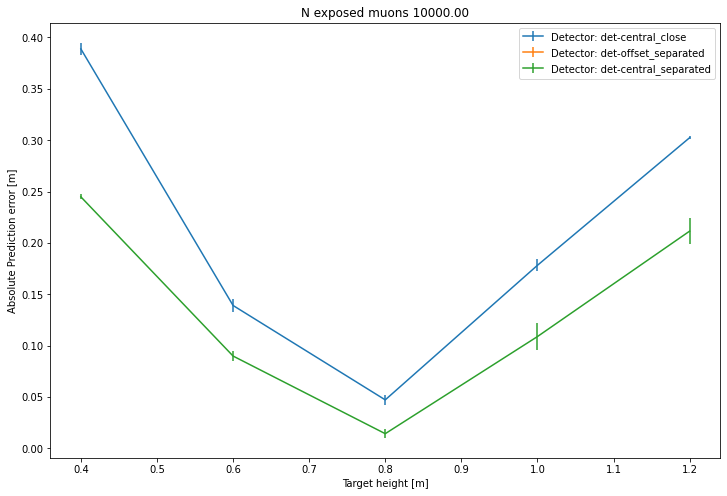

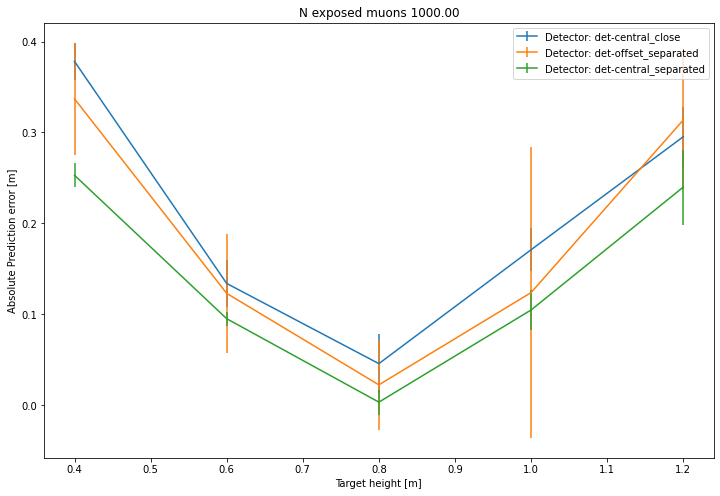

In [10]:
for n_mu in df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(df.detector.unique()):
            sdf = df.loc[(df.detector == det) & (df.n_mu == n_mu), ['targ_h', 'bias', 'new_bias']].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['bias', 'new_bias']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, (agg.new_bias_mean-agg.new_bias_mean.mean()).abs(), yerr=agg.new_bias_std, label=f'Detector: {det}', color=pallete[i])
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Absolute Prediction error [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

# Correction

In [12]:
df

,detector,n_mu,targ_h,pred_h,n_rec_muons,mean_z_unc,mean_z,mean_xy_unc,mean_xy_sig_wgt,std_xy_sig_wgt,std_wgt,mean_wgt,new_pred,bias,new_bias,basic_bias
0,det-central_close,10000,0.4,0.496187,2052,1.134189,0.659549,0.159979,0.549890,0.186908,4.576799e+04,1.174956e+04,0.685371,-0.096187,-0.285371,-0.259549
1,det-central_close,10000,0.4,0.504192,2019,1.330096,0.687285,0.191751,0.550723,0.184706,5.135880e+04,1.312834e+04,0.699910,-0.104192,-0.299910,-0.287285
2,det-central_close,10000,0.4,0.472770,1995,1.492392,0.654664,0.163603,0.550332,0.189412,6.831076e+04,1.406783e+04,0.689861,-0.072770,-0.289861,-0.254664
3,det-central_close,10000,0.4,0.528312,2003,1.738766,0.670997,0.209833,0.551093,0.188189,5.277521e+04,1.482665e+04,0.692561,-0.128312,-0.292561,-0.270997
4,det-central_close,10000,0.6,0.500866,2006,1.085430,0.617339,0.143955,0.573492,0.176462,5.642859e+04,1.577536e+04,0.634601,0.099134,-0.034601,-0.017339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,det-central_separated,10000,1.2,0.486259,1306,0.038950,0.796650,0.004003,0.645288,0.148243,6.026200e+06,3.051730e+06,0.798045,0.713741,0.401955,0.403350
214,det-central_separated,10000,1.2,0.489445,1377,0.076020,0.761337,0.007833,0.632938,0.155035,6.198842e+06,3.448522e+06,0.761337,0.710555,0.438663,0.438663
215,det-central_separated,10000,1.2,0.505610,1417,0.042827,0.784456,0.004022,0.648892,0.149662,7.502611e+06,3.461192e+06,0.784455,0.694390,0.415545,0.415545
216,det-central_separated,10000,1.2,0.468158,1418,0.044814,0.797469,0.003896,0.639778,0.151883,6.233061e+06,3.237780e+06,0.797469,0.731842,0.402531,0.402531


In [31]:
from torch import Tensor, nn, optim
import torch

In [106]:
from lumin.nn.losses.advanced_losses import WeightedFractionalMSE

In [133]:
x = Tensor(df.loc[(df.detector == 'det-central_separated') & (df.n_mu == 1000), 'new_pred'].values)[:,None]
y = Tensor(df.loc[(df.detector == 'det-central_separated') & (df.n_mu == 1000), 'targ_h'].values)[:,None]

In [134]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [143]:
opt = optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [144]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(1, loss.item())

1 0.003945770673453808
1 0.003925031516700983
1 0.0039235628210008144
1 0.003922780975699425
1 0.003922030795365572
1 0.0039212931878864765
1 0.003920563030987978
1 0.003919842187315226
1 0.0039191292598843575
1 0.003918426111340523
1 0.003917731810361147
1 0.00391704635694623
1 0.0039163678884506226
1 0.003915698733180761
1 0.003915039356797934
1 0.003914384171366692
1 0.00391374109312892
1 0.003913102205842733
1 0.00391247496008873
1 0.003911853767931461
1 0.003911241423338652
1 0.00391063466668129
1 0.00391003442928195
1 0.0039094435051083565
1 0.003908859565854073
1 0.003908282145857811
1 0.003907713107764721
1 0.003907152451574802
1 0.00390659412369132
1 0.003906046971678734
1 0.003905502613633871
1 0.0039049703627824783
1 0.003904439276084304
1 0.0039039170369505882
1 0.0039034015499055386
1 0.0039028911851346493
1 0.0039023873396217823
1 0.0039018907118588686
1 0.0039013999048620462
1 0.0039009153842926025
1 0.0039004345890134573
1 0.003899963805451989
1 0.003899496514350176
1 0

1 0.003862608689814806
1 0.0038626010064035654
1 0.003862593090161681
1 0.0038625868037343025
1 0.00386258028447628
1 0.0038625728338956833
1 0.0038625658489763737
1 0.003862557699903846
1 0.003862552111968398
1 0.003862544195726514
1 0.0038625397719442844
1 0.0038625311572104692
1 0.003862525336444378
1 0.003862520679831505
1 0.0038625127635896206
1 0.003862508572638035
1 0.0038625020533800125
1 0.00386249553412199
1 0.003862489713355899
1 0.0038624850567430258
1 0.003862478770315647
1 0.00386247131973505
1 0.0038624668959528208
1 0.003862460609525442
1 0.0038624554872512817
1 0.003862449200823903
1 0.00386244454421103
1 0.0038624382577836514
1 0.0038624329026788473
1 0.0038624280132353306
1 0.00386242289096117
1 0.003862417535856366
1 0.0038624126464128494
1 0.0038624100852757692
1 0.0038624031003564596
1 0.0038623977452516556
1 0.0038623916916549206
1 0.003862388664856553
1 0.0038623842410743237
1 0.0038623791188001633
1 0.0038623742293566465
1 0.003862371202558279
1 0.0038623667787

1 0.003862017299979925
1 0.003862016135826707
1 0.0038620170671492815
1 0.0038620170671492815
1 0.0038620156701654196
1 0.003862016135826707
1 0.003862016135826707
1 0.0038620152045041323
1 0.0038620156701654196
1 0.003862016135826707
1 0.003862016135826707
1 0.0038620156701654196
1 0.0038620145060122013
1 0.0038620149716734886
1 0.003862016601487994
1 0.0038620152045041323
1 0.003862016135826707
1 0.0038620156701654196
1 0.0038620156701654196
1 0.0038620149716734886
1 0.003862016135826707
1 0.003862016135826707
1 0.0038620149716734886
1 0.0038620156701654196
1 0.0038620145060122013
1 0.0038620138075202703
1 0.003862014738842845
1 0.0038620145060122013
1 0.0038620152045041323
1 0.0038620145060122013
1 0.0038620152045041323
1 0.0038620149716734886
1 0.003862014040350914
1 0.0038620145060122013
1 0.0038620145060122013
1 0.0038620124105364084
1 0.003862014040350914
1 0.003862014738842845
1 0.0038620152045041323
1 0.003862014040350914
1 0.0038620149716734886
1 0.0038620138075202703
1 0.003

1 0.0038620103150606155
1 0.003862009383738041
1 0.003862011479213834
1 0.0038620117120444775
1 0.0038620117120444775
1 0.00386201124638319
1 0.0038620098493993282
1 0.003862009383738041
1 0.0038620096165686846
1 0.003862010780721903
1 0.00386201124638319
1 0.003862011479213834
1 0.003862010547891259
1 0.00386201124638319
1 0.0038620096165686846
1 0.003862010547891259
1 0.0038620098493993282
1 0.00386200868524611
1 0.003862010547891259
1 0.003862010547891259
1 0.0038620098493993282
1 0.0038620096165686846
1 0.0038620103150606155
1 0.003862011479213834
1 0.00386201124638319
1 0.0038620103150606155
1 0.003862011479213834
1 0.0038620098493993282
1 0.003862010780721903
1 0.0038620117120444775
1 0.0038620103150606155
1 0.0038620098493993282
1 0.003862011479213834
1 0.00386201124638319
1 0.003862009383738041
1 0.0038620103150606155
1 0.0038620103150606155
1 0.003862010780721903
1 0.003862010547891259
1 0.003862010547891259
1 0.0038620117120444775
1 0.003862010547891259
1 0.003862011479213834

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.0038620082195848227
1 0.003862008219

In [145]:
corr_layer.weight, corr_layer.bias

(Parameter containing:
 tensor([[2.3370]], requires_grad=True),
 Parameter containing:
 tensor([-0.5844], requires_grad=True))

In [123]:
(x-y).mean()

tensor(-0.0935)

In [128]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0935

In [146]:
df['new_new_pred'] = corr_layer(Tensor(df.new_pred.values[:,None])).detach().cpu().numpy()

In [147]:
df['new_new_bias'] = df.targ_h-df.new_new_pred

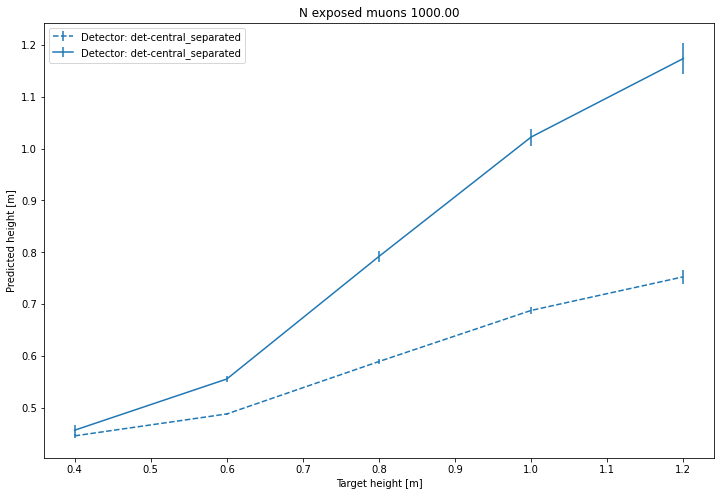

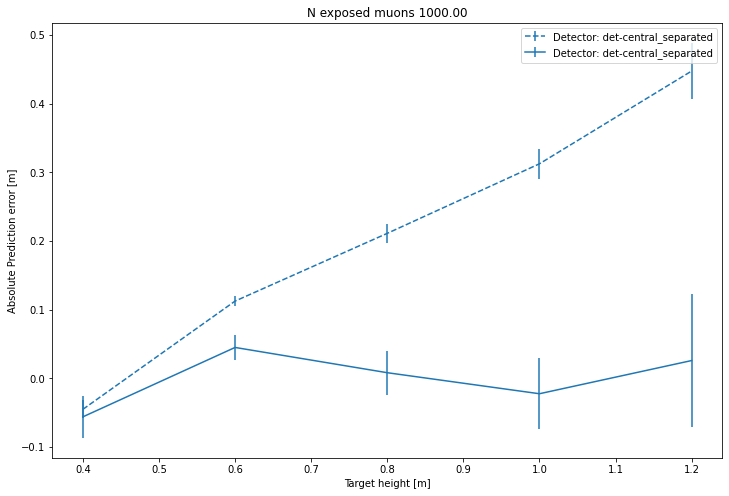

In [148]:
for n_mu in [1000]:#df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(['det-central_separated']):#df.detector.unique()):
            sdf = df.loc[(df.detector == det) & (df.n_mu == n_mu), ['targ_h', 'new_pred', 'new_new_pred']].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['new_pred','new_new_pred']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, agg.new_pred_mean, yerr=agg.new_pred_std/np.sqrt(10), label=f'Detector: {det}', color=pallete[i],  linestyle='--')
            plt.errorbar(agg.targ_h, agg.new_new_pred_mean, yerr=agg.new_new_pred_std/np.sqrt(10), label=f'Detector: {det}', color=pallete[i])
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Predicted height [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

for n_mu in [1000]:#df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(['det-central_separated']):#df.detector.unique()):
            sdf = df.loc[(df.detector == det) & (df.n_mu == n_mu), ['targ_h', 'new_bias', 'new_new_bias']].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['new_bias','new_new_bias']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)

            plt.errorbar(agg.targ_h, agg.new_bias_mean, yerr=agg.new_bias_std, label=f'Detector: {det}', color=pallete[i], linestyle='--')
            plt.errorbar(agg.targ_h, agg.new_new_bias_mean, yerr=agg.new_new_bias_std, label=f'Detector: {det}', color=pallete[i])
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Absolute Prediction error [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()